In [2]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv("E:\\leonhardt\\mayi\\data\\train.csv")

In [3]:
df_train=df_train.loc[df_train['label']!=-1]

In [4]:
df_train = df_train.fillna(0)

In [5]:
train_set = df_train[df_train.loc[:, "date"]<=20171005]
eva_set = df_train[df_train.loc[:, "date"]>20171005]

In [6]:
train_label = train_set.loc[:, "label"]
eva_label = eva_set.loc[:, "label"]

In [7]:
train_set.drop(["id","date", "label"], axis=1, inplace=True)
eva_set.drop(["id","date", "label"], axis=1, inplace=True)

D:\anaconda\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
import lightgbm as lgb
lgb_train=lgb.Dataset(train_set,train_label,free_raw_data=False)
lgb_valid=lgb.Dataset(eva_set,eva_label,reference=lgb_train,free_raw_data=False)
params = {'boosting_type': 'gbdt',
          'objective': 'binary', 
          'metric': 'auc', 
          'device': 'cpu', 
          'verbose': 0, 
          'learning_rate': 0.01, 
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'feature_fraction': 0.9,
          'lambda_l1': 0.006, 
          'num_leaves': 70,
          'early_stopping_round': 30
}

In [20]:
from sklearn.metrics import roc_auc_score,roc_curve
def atec_metric(preds, train_data):
    labels = train_data.get_label()
    fpr,tpr,threshhold=roc_curve(labels, preds)
    return 'atec_metric', 0.4*tpr[fpr<=0.001][-1] + 0.3*tpr[fpr<=0.005][-1] + 0.3*tpr[fpr<=0.01][-1], True

# gbm=lgb.train(params, lgb_train, num_boost_round=1500, valid_sets=lgb_valid, valid_names='valid_set', feval=atec_metric, verbose_eval=200)
gbm = lgb.LGBMClassifier(boosting_type = 'gbdt',
          objective='binary', 
          metric='auc', 
#           device=cpu', 
          verbose=0, 
          learning_rate=0.01, 
          bagging_fraction=0.8,
          bagging_freq=5,
          feature_fraction=0.9,
          lambda_l1=0.006, 
          num_leaves=70,
          num_boost_round=343
#           early_stopping=30
)
gbm.fit(train_set, train_label)

D:\anaconda\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
        lambda_l1=0.006, learning_rate=0.01, max_depth=-1, metric='auc',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_boost_round=343, num_leaves=70,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1, verbose=0)

In [22]:
y_pred = gbm.predict(df_test)

D:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
np.savetxt("E:\\leonhardt\\mayi\\mayi\\ipython\\prediction/highest_score.txt", y_pred, delimiter=",")

In [24]:
y_prob = gbm.predict_proba(df_test)

In [26]:
def atec_metric(preds, labels):
    fpr,tpr,threshhold=roc_curve(labels, preds)
    return 'atec_metric', 0.4*tpr[fpr<=0.001][-1] + 0.3*tpr[fpr<=0.005][-1] + 0.3*tpr[fpr<=0.01][-1], True

atec_metric(y_prob[:,1],y_pred)

('atec_metric', 1.0, True)

<Figure size 432x288 with 0 Axes>

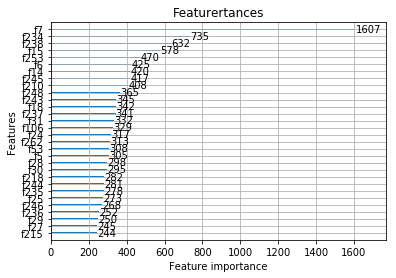

In [9]:
plt.figure()
lgb.plot_importance(gbm, max_num_features=30)
plt.title("Featurertances")
plt.show()

In [21]:
df_test = pd.read_csv("E:\\leonhardt\\mayi\\data\\test_a.csv")
df_test = df_test.fillna(0)
df_test.drop(["date","id"],axis=1, inplace=True)

In [11]:
y_pred = gbm.predict(df_test)

In [12]:
np.savetxt("E:\\leonhardt\\mayi\\mayi\\ipython\\prediction/lgb_simple_fill0.txt", y_pred, delimiter=",")

In [13]:
y_pred.max()

0.8758211549447386

In [14]:
y_pred.min()

0.016513100918954936

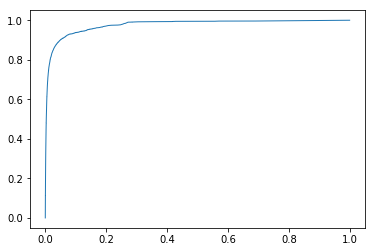

In [15]:
from scipy import interp  
from sklearn.metrics import auc
mean_tpr = 0.0  
mean_fpr = np.linspace(0, 1, 100)  
all_tpr = []  

fpr, tpr, thresholds = roc_curve(eva_label, gbm.predict(eva_set))  
mean_tpr += interp(mean_fpr, fpr, tpr)          #对mean_tpr在mean_fpr处进行插值，通过scipy包调用interp()函数  
mean_tpr[0] = 0.0                               #初始处为0  
roc_auc = auc(fpr, tpr)  
#画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来  
plt.plot(fpr, tpr, lw=1, label='ROC fold (area = %0.2f)' % ( roc_auc))